In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import boxcox
from scipy.stats import norm
from tqdm.auto import tqdm

plt.style.use('ggplot')

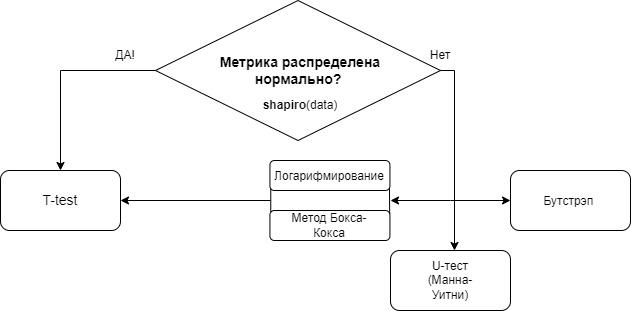

In [76]:
# Способы найти статистически значимый результат
from IPython import display
display.Image("./p-value_calculation_flow.jpg")

### Задача: средний чек тестовой группы больше, чем средней чек тестовой группы?

### Что предстоит: 
1. Посмотреть на данные. Понять, что метрика не подчиняется нормальному распределению 
2. Применить Логарифмирование и T-test
3. Применить Метод Бокса-Кокса и T-test
4. Применить U-test
5. Применяем Бутстрэп

In [77]:
data = pd.read_csv("ecom_data_students.csv")
data.head()

# InvoiceNo — идентификатор чека.
# StockCode — идентификатор товара.
# Description — описание товара.
# Quantity — количество товара в чеке.
# InvoiceDate — дата покупки.
# ..........
# UnitPrice — стоимость товара в чеке.
# ..........
# CustomerID — идентификатор пользователя.
# Country — страна 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,GroupType
0,571664,22302,COFFEE MUG PEARS DESIGN,72,10/18/2011 12:59,2.100,17090.0,United Kingdom,control
1,573585,23086,ZINC STAR T-LIGHT HOLDER,1,10/31/2011 14:41,2.952,NaN,United Kingdom,test
2,556905,84596F,SMALL MARSHMALLOWS PINK BOWL,1,6/15/2011 13:05,0.420,16904.0,United Kingdom,control
3,561710,21066,VINTAGE RED MUG,1,7/29/2011 11:45,1.500,13827.0,United Kingdom,test
4,560078,22570,FELTCRAFT CUSHION RABBIT,4,7/14/2011 16:12,4.500,16040.0,United Kingdom,test


### Data preparation ###

<AxesSubplot:>

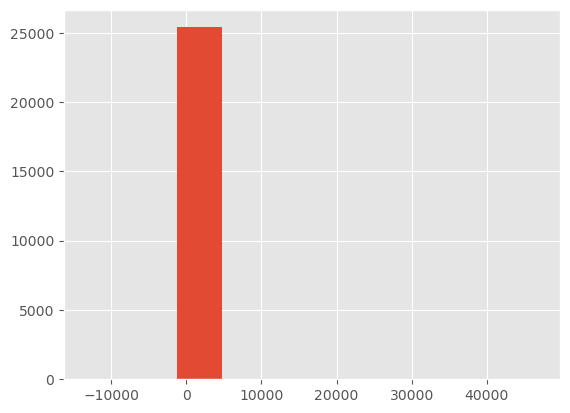

In [78]:
data.groupby('InvoiceNo').UnitPrice.sum().hist()

In [79]:
# Удаление возвратов (отрицательных значений чеков)
data = data[data.UnitPrice > 0]

<AxesSubplot:xlabel='UnitPrice', ylabel='Count'>

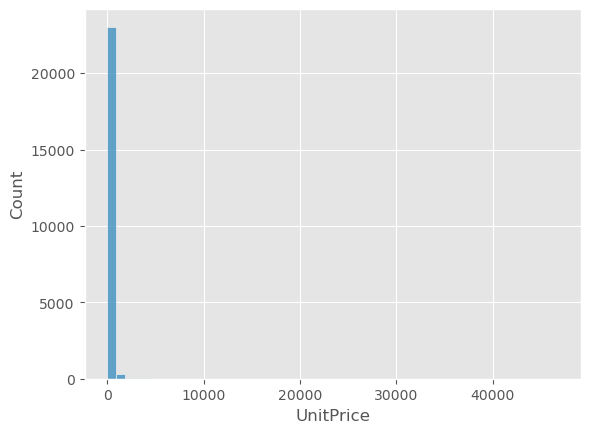

In [80]:
#Еще раз смотрим. Минусовых значений нет, но график явно не похож на нормальное распределение
sns.histplot(data.groupby('InvoiceNo').UnitPrice.sum(), bins=50)

#### График показал, что распределение ненормальное. Надо применять методы трасформации данных ####

### Измеряем разницу этих двух значений: 

In [106]:
#Средний чек тестовой группы
data[data.GroupType == "test"].groupby("InvoiceNo").UnitPrice.sum().mean()

160.97060348944015

In [107]:
#Средний чек контрольной групы 
data[data.GroupType == "control"].groupby("InvoiceNo").UnitPrice.sum().mean()

56.361897556299915

### Логарифмирование: первый метод трансформации данных ###

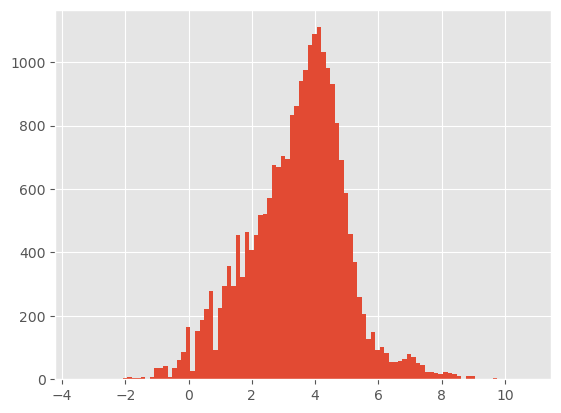

In [83]:
from matplotlib import pyplot

log_mean_bills = data.groupby("InvoiceNo").UnitPrice.sum().apply(lambda x: np.log(x)).values.tolist()

plt.hist(log_mean_bills, bins=100)
plt.show()

In [84]:
# Воспользуемся функцией shapiro из scipy.stats, которая вернёт статистику критерия Шапиро-Уилка и p-value. 
# При p_value < alpha мы можем отвергнуть нулевую гипотезу
# Нулевая гипотеза: выборка не является стандартным распределением

In [85]:
stat, p_value = shapiro(log_mean_bills)
print(f'stat={stat}, p-value={p_value}')

alpha = 0.05
if p_value < alpha:
    print('Ура, первую гипотезу отклоняем. Распределение нормальное! Айда проводить t-test')
else:
    print('Блин, первую гипотезу не отклоняем. Распределение ненормальное!')


stat=0.9867736101150513, p-value=2.749627846698156e-41
Ура, первую гипотезу отклоняем. Распределение нормальное! Айда проводить t-test


C:\Users\user\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### T-test

In [86]:
stat, p_value = ttest_ind(data[data.GroupType == "test"].groupby("InvoiceNo").UnitPrice.sum().apply(lambda x: np.log(x)).values.tolist(),
             data[data.GroupType == "control"].groupby("InvoiceNo").UnitPrice.sum().apply(lambda x: np.log(x)).values.tolist())
alpha = 0.05
if p_value < alpha:
    print('Ура, первую гипотезу отклоняем. test выборка лучше!')
else:
    print('Блин, первую гипотезу не отклоняем. control выборка лучше')

Ура, первую гипотезу отклоняем. test выборка лучше!


##### Итоги логарифмирования: мы трансформировали данные, убедились в нормальноти выборки и провели t-test. Подтвердили успех эксперимента

### Метод Бокса-Кокса: второй метод трансформации данных (преобразование оптимальным образом) ###

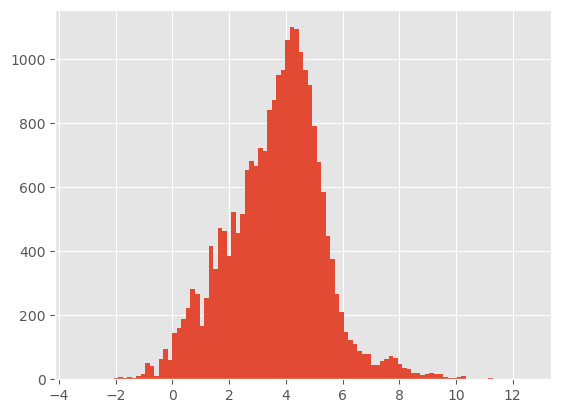

In [87]:
boxcox_mean_bills, fitted_lambda = boxcox(data.groupby("InvoiceNo").UnitPrice.sum().values.tolist())

pyplot.hist(boxcox_mean_bills, bins=100)
pyplot.show()

In [88]:
stat, p_value = shapiro(boxcox_mean_bills)
print(f'stat={stat}, p-value={p_value}')

alpha = 0.05
if p_value < alpha:
    print('Ура, первую гипотезу отклоняем. Распределение нормальное! Айда проводить t-test')
else:
    print('Блин, первую гипотезу не отклоняем. Распределение ненормальное!')

stat=0.9874487519264221, p-value=1.876226539853784e-40
Ура, первую гипотезу отклоняем. Распределение нормальное! Айда проводить t-test


C:\Users\user\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### T-test

In [89]:
test = boxcox(data[data.GroupType == "test"].groupby("InvoiceNo").UnitPrice.sum().values.tolist())

In [90]:
control = boxcox(data[data.GroupType == "control"].groupby("InvoiceNo").UnitPrice.sum().values.tolist())

In [91]:
stat, p_value = ttest_ind(test[0], control[0])
alpha = 0.05
if p_value < alpha:
    print('Ура, первую гипотезу отклоняем. test выборка лучше!')
else:
    print('Блин, первую гипотезу не отклоняем. control выборка лучше')

Ура, первую гипотезу отклоняем. test выборка лучше!


##### Итоги метода Бокса-Кокса: мы трансформировали данные, убедились в нормальноти выборки и провели t-test. Потвертили успех эксперимент

### Применим U-test

In [92]:
stat, p_value = mannwhitneyu(data[data.GroupType == "test"].groupby("InvoiceNo").UnitPrice.sum().values, 
             data[data.GroupType == "control"].groupby("InvoiceNo").UnitPrice.sum().values)
print("{0} — статистика, а {1} — p_value.".format(stat,p_value))

alpha = 0.05
if p_value < alpha:
    print('Ура, первую гипотезу отклоняем. test выборка лучше!')
else:
    print('Блин, первую гипотезу не отклоняем. control выборка лучше')

75034245.5 — статистика, а 4.046344316898649e-40 — p_value.
Ура, первую гипотезу отклоняем. test выборка лучше!


##### Итоги метода Манна-Уитни: мы потвертили успех эксперимент. Трансформировать ничего не нужно было

### Применим Бутстрэп

In [93]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = np.random.choice(data_column_1, size=boot_len, replace=True)
        samples_2 = np.random.choice(data_column_2, size=boot_len, replace=True)
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return { "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

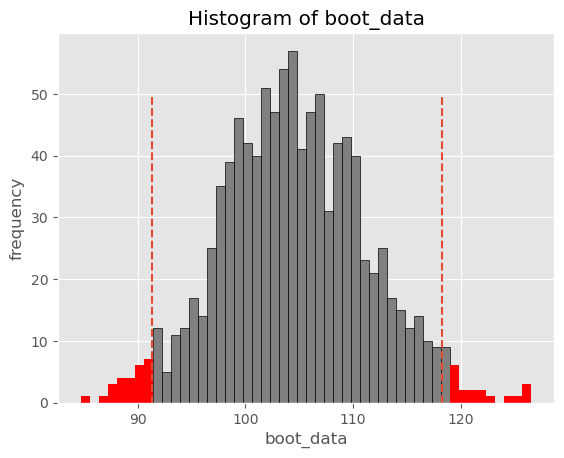

{'quants':                 0
 0.025   91.355156
 0.975  118.245403,
 'p_value': 3.361883056967615e-54}

In [94]:
get_bootstrap(
    data[data.GroupType == "test"].groupby("InvoiceNo").UnitPrice.sum().values.tolist(),
    data[data.GroupType == "control"].groupby("InvoiceNo").UnitPrice.sum().values.tolist(),
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)
#Серое - 95% доверительный интервал 


Вывод: ноль находится вне доверительного интервала, отличия статистически значимы

##### Итоги метода бутстрэп: мы потвертили успех эксперимент, нововеденния оказались лучше

### Применим Бутстрэп (способ 2)

100%|██████████| 10000/10000 [00:30<00:00, 332.92it/s]


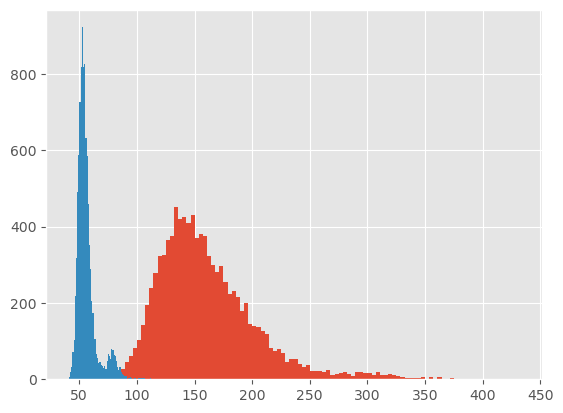

Control 95 percentile: 78.16725166666666
Test 5 percentile: 107.4521344


In [96]:
np.random.seed(1)
from tqdm import tqdm

all_values_test = data[data.GroupType == "test"].groupby("InvoiceNo").UnitPrice.sum().values.tolist()
all_values_control = data[data.GroupType == "control"].groupby("InvoiceNo").UnitPrice.sum().values.tolist()

sample_mean_test = []
sample_mean_control = []

for i in tqdm(range(10000)):
    sample_n = np.random.choice(all_values_test, size=300)
    sample_mean_test.append(sample_n.mean())

    sample_n = np.random.choice(all_values_control, size=300)
    sample_mean_control.append(sample_n.mean())


pyplot.hist(sample_mean_test, bins=100)
pyplot.hist(sample_mean_control, bins=100)
pyplot.show()
print(f"Control 95 percentile: {np.percentile(sample_mean_control, 95)}")
print(f"Test 5 percentile: {np.percentile(sample_mean_test, 5)}")

5 перцентиль тестового распределения больше, чем 95 перцентиль контрольного. Значит, различия статистически значимые

In [111]:
np.mean(sample_mean_test)/np.mean(sample_mean_control)

2.8618860730262368

100%|██████████| 10000/10000 [00:30<00:00, 330.42it/s]


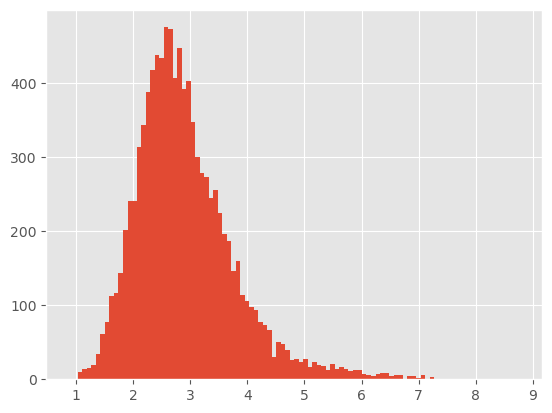

1.600742658011728 5.184796070320841


In [98]:
np.random.seed(1)
sample_mean_ratio = []

for i in tqdm(range(10000)):
    sample_test = np.random.choice(all_values_test, size=300)
    sample_control = np.random.choice(all_values_control, size=300)
    
    sample_mean_ratio.append(sample_test.mean() / sample_control.mean())


pyplot.hist(sample_mean_ratio, bins=100)
pyplot.show()
print(np.percentile(sample_mean_ratio, 2.5), np.percentile(sample_mean_ratio, 97.5))

Итоги эсперимента: средний чек вырос в 2.9 раза! Если ввести нововведения, то мы увидим прирост в диапазоне от 
1.6 до 5.1.

Так как распределение среднего чека не является нормальным, мы провели бутстрэп сэмплирование. А также для уверенности: U-test, логарифмирование, метод Бокса-Кокса. Все расчеты показали, что значимые различия присутствуют. 